<a href="https://colab.research.google.com/github/Juanmeve837/ML_for_Production_Prediction/blob/main/CTGAN_synthesizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
%pip install summarytools -q
%pip install sdv -q


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from summarytools import dfSummary
from sdv.metadata import Metadata
import requests
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import run_diagnostic
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot

In [43]:
url = "https://raw.githubusercontent.com/Juanmeve837/ML_for_Production_Prediction/refs/heads/main/assets/performance_full.csv"
url_metadata = "https://raw.githubusercontent.com/Juanmeve837/ML_for_Production_Prediction/refs/heads/main/CGAN/my_metadata_v1.json"

In [44]:
df = pd.read_csv(url, sep=";")

In [45]:
df.drop(columns=['date'], inplace=True)

In [60]:
df = df[df["performance"]>0]

In [61]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,hours_machine[float64],Mean (sd) : 11.3 (5.0)min < med < max:0.2 < 9.4 < 22.1IQR (CV) : 6.3 (2.3),316 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAArpJREFUeJzt3EGK4kAUgOFXYytRIUF60J0XGJiFSw8xh50jjOAJvIE7IUjETAdjzGxHaNSkkq56yf/tiy7CTydVXV2mLEsBfPfN9QSAV7y5noCvjDFjERnVHH4py/Kjyfn0HaF+whgzfn9//xWG4azO+NPpdDTG/CbW5hDq50ZhGM7W6/VHFEVZlYFJkgTb7XYWx/FIRAi1IYT6QBRF2Xw+/1tj6LjxyfQciymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpU6OwFFJZ3R4W3223Y5Hxgp5Oh2t4dled5UBTFjyzL/ohInZtS0LBOhioWd0eJiOz3+9lut5tcr9dBG5PzleVbSKTFWwy7GqqI1L876ng89u7uKNu3kEi7txh2OlRUYvUWavsWQ0LFHYsbDEVavMWQ7SmoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQJ/6/eMz0ftXCJUj/h+1M4lQvWL10ftXCJUD/l61M4lFlNQgVChAqFCBUKFCl4vpiz2FHt7gURRFEMRCY0xVYd6/cy8DdVmT7GvF0ikaTrM8/zncrkcDAaDSttbvj8zb0MViz3Fvl4gcblc3oIgmKxWq2yxWByrjPX9mfkcqojU21N0fYGE69fvdDpV98ye8T5Ubbr8+nXpaaiWhyQ6eUDikS6/fl16GKrtIYmuHpB4RRdfvy49+41ae0GTJEmw2WzmcRx/N8acaszN6+0SfK2XvlHrLGhsvtVE+F7DvdYWUzbfaiJ8r+Fe66v+Ot9qInyv4R7bU2iMxf6xyJMdIkJFI2zXJM92iAgVjbBZk7zyLzQvhZokSVDlB4uInM/nQEQkTdPgcDhMvnK81p+tdd7/j2/LP+A7pPHX0tJGAAAAAElFTkSuQmCC"">",0(0.0%)
2,idle_percentage[float64],Mean (sd) : 16.5 (12.1)min < med < max:0.0 < 14.0 < 82.0IQR (CV) : 9.9 (1.4),147 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAs9JREFUeJzt3b1TGkEYgPF3QczKxx1Ioh1NCmZ0JgWljV3K/LFp06XQGmNLkbFxHB3AcIGwHqTIWMURbhfCvZfn1+/dFs/B7DG+muVyKUDelXa9AWAde9u8uDHmQET2Ay4xXy6X003tB3ptLVRjzEG73f4URVHL9xqPj49DY8xnYsU2P1H3oyhqnZ2dTeM4nmVdPB6P7cXFRevh4WFfRAj1P7fVr34RkTiOZ0dHRz89lx9sdDNQi8MUVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFbb+d/0h0jStiEhkjPFZzjigAsltqEmSVJxzHzqdTrlcLmeetMI4oGLJbajz+XzPWlvt9Xqz4+PjYZa1jAMqntyG+qxWq/mOBGIcUIFwmIIKhAoVCBUqECpUIFSosPLUHzCHP1osFhWPdcBfXg01ZA6/c86maXo6m82+iojvxGlARFZ/onrP4b+5uWldX19Xn56eygH7A0RkzRf+PnP4h8MhL9yxMRymoAKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQIfeTUnwFDlgTYcharhQy1NABayIMWcubQoYaMmBNhCFreVTIUJ8FDFgTYcharnCYggqEChUIFSoQKlQo9GEqBP/oIl8I9QWh72FHo9HEGPNFRHze4ZZEZOGx7tnOHpKAgXoiK/ZNqC8IeQ97e3vbuLy8PO90Om+zRp6maSVJkvf1en1QKpVctl3/scOHxB4eHn6M47jms3jVDyxrhToej23WG08mEysikiSJvbu7q/7L9Zu6tw/n3J61ttrtdk2z2fyVZe39/b0dDAbvut3u92azOcl679FoVO/3+zt5SJxzVkROT05OvjUajR9Z1k6n0zdXV1ev/sDyGyhTH230uAaBAAAAAElFTkSuQmCC"">",0(0.0%)
3,operating_percentage[float64],Mean (sd) : 83.5 (12.1)min < med < max:18.0 < 86.0 < 100.0IQR (CV) : 9.8 (6.9),147 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAr5JREFUeJzt3b1v2kAYgPH3ICDzZQuoyMbSjUgMjCzdOvaP7dqtA0M3VNZObCgRkOKG4th0aCNlgvjOrv1az2/O2Tc8SnKW/Nqcz2cByq5W9AaAt7gpegMoD2NMS0SaDpc4nc/np6z28xqhQkT+RjocDj/5vt+3vcbj4+PWGPM5j1gJFS+avu/35/P5UxAEx7SL9/u9t1gs+g8PD00RIVTkKwiC42g0+mW5vJXpZl7hMAUVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECr0tXjMO0Ez9JkkbW+8kKoVaIy7STKIq8OI7vjsfjVxGxfa8/N4RaLdbTTtbrdX+1WrWfn5/reW3OBaFWkM20k+12m9uUkyxwmIIKhAoVCBUqECpU4DCFzMRx3BAR3xhjs/zitGpCRSbCMGxEUTQdj8f1er2eehDwtWnVhIpMnE6nG8/z2rPZ7Hh7e7tNs/Yt06oJFZnqdDq2E6svPsflMAUVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSrwKkrJOEzjEyn5RD4XhFoiLtP4RMo/kc8FoZaL9TQ+kfJP5HNBqCVkM41PpPwT+VxwmIIKhAoVCBUq8D9qDqr6wYciEWrGqvzBhyJdDdXxAfTFUYJ5cty3iP3eK/vBhyJdDNX1AfRutzsYY76ISOpngv/URCSxWOcNBoOPQRB0LO/rsnc/SZJGEATbqn3woUjXfqM2fd/vT6dTabVav9NceLfbdZfL5YfxePzOZl5mHMeNMAzfd7vdH7VaLUqzNooiT0TuJpPJ916v9zPtvV32/vLn+/7+/lva+x4OB09EJAxDb7PZtP/n+iLvvd/vvWs/8wd13g1+yuxiKwAAAABJRU5ErkJggg=="">",0

In [62]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=df,
    table_name='df')

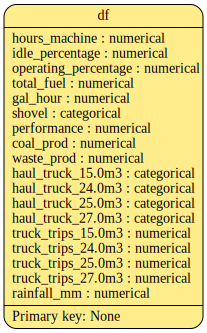

In [63]:
metadata.visualize()

In [47]:
#response = requests.get(url_metadata)
#response.raise_for_status()

#metadata_filename = "my_metadata_v1.json"
#with open(metadata_filename, "w") as f:
#    f.write(response.text)

#metadata = Metadata.load_from_json(metadata_filename)

In [64]:
metadata.save_to_json(filepath='my_metadata_v2.json')

In [65]:
synthesizer = CTGANSynthesizer(
    metadata,
    epochs=1000,
    verbose=True)
synthesizer.fit(df)

Gen. (-0.65) | Discrim. (-0.30): 100%|██████████| 1000/1000 [01:55<00:00,  8.67it/s]


In [66]:
synthetic_data = synthesizer.sample(num_rows=2500)

In [67]:
synthetic_data.shape

(2500, 18)

In [68]:
dfSummary(synthetic_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,hours_machine[float64],Mean (sd) : 10.9 (5.6)min < med < max:0.2 < 9.9 < 22.1IQR (CV) : 7.5 (1.9),"2,169 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAsNJREFUeJzt3b2O2kAUQOE7sCDzIyNEAh1NykgpXPIQedg8QpD2CSi2SUWHZCEjnLUwhhRRIqGswPZ4lrnkfP2Ai2Njj43HnM9nAXzXuvcGAGU83XsDXDHG9ESka/ERh/P5/NrU9sDOQ4ZqjOlNJpOvYRiO637GbrfbGmO+EasfHjJUEemGYTheLBavo9Eoqzo4SZLg+fl5HMdxV0QI1QOPGqqIiIxGo2w6nf6sObzX6MbAChdTUIFQoQKhQgVChQqEChUIFSoQKlQgVKjw0BP+Noqi6IhIaIypM5znBBpGqG9I07ST5/mX+XzebrfblW/B8pxA8wj1DYfD4SkIgn4URdlsNttWGctzAm4Q6hWDwaDuswI8J9AwLqagAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUq8C9UB3h5RfMItWG8vMINQm0YL69ww+tQLdaKCk+nU6fp7amCl1c0y9tQbdaKyvM8KIric5Zl30Wk7qooqMhyEbqr5+behioWa0Wt1+vxarXqH4/HtquNwyXbRehunZvfDNXlXlJGnbWittstP5/vr/aBpcy5+dVQXe8leDwWi9BdPbjcOqI63UvwL8s5WJHfN3FONcd6O4db6hzV1V6CS7ZzsEVRdNI0/TQcDn+0Wq286niffwF9vpj679jMwYr8vYj8GEXRS5053OVyOY3j+IMxZlf1u8XxlCCheqjuHOyfi8g6422P5q6nBAkVItLY0dzZlCCh4oLt0dwVHvODCoQKFQgVKhAqVCBUqECoUIFQoQKhQgWnE/6WTwLd/e8k8IezUH2/dwxdnIXq+71j6OL8Xr+v946hCxdTUIFQoQKhQgVChQqlLqaSJAmqfvB+vw9ERNI0DTabTf89x2v9bq3bbTu+TF+/AHjrsKdyNQZWAAAAAElFTkSuQmCC"">",0(0.0%)
2,idle_percentage[float64],Mean (sd) : 14.7 (14.7)min < med < max:0.0 < 11.3 < 82.0IQR (CV) : 11.9 (1.0),"2,376 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAArlJREFUeJzt3TFv2kAchvH/QSCGoLMsWrJl6RipA6M/RD5sP0IjMXRm6NKJLQpCoLggHEOXplOaYB9Qv+7z28+2okeX2Jez3X6/N6DuWv/6AoBDXJzy4M65npl1Aw6x3e/362NdD3SdLFTnXG84HN5575Oqx1itVgvn3BdixbuhBsyKfjAYjNI0XcVxvCk7eLlcRpPJJJnP510zI9T/3JuhhsyKeZ5HRVHcXl5efh2NRj8rXl+v4jg0zHszatd7n6Rpui47K85ms2Q6nfafn5/bAdcHmNmBf6PGcbwpOysuFgtmQxwNj6cggVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAh4aQfmwhVFEXHzLxzrspwPlTRILUNNcuyTp7nn29ubtrtdrv0NwD4UEWz1DbU7XZ7EUVRfzweb66vrxdlxvKhiuapbagvrq6uSr+W/Tdezd4g3ExBAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCQu3/za+qwN0BZuwQqJVGhhq6O8CMHQJ108hQQ3YHmLFDoI4aGeqLgN0BZuwQqBVupiCBUCGBUCGBUCGh0TdTOC/nXM/MuhWHv/ncmlD/InDBoGVmu4qnllxocM71hsPhnfc+qTL+vefWhPqKkAWDoig6WZZ9GgwGP1qtVl723MILDV3vfZKm6TqO41I/s0OeWxPqK0IWDGazWTKdTj+Ox+PvVV5FdH9/P5rP5x+cc6tyV/1HyGweMtbvdrtOHMeLU7zZ5qBQl8tlVPasT09PkZlZlmXRw8ND/5zjj3Xuc1uv10FLvyGzeehvgjzPo6Iobh8fH7+VHXtIX78AE6smNsA8DisAAAAASUVORK5CYII="">",0(0.0%)
3,operating_percentage[float64],Mean (sd) : 75.2 (17.0)min < med < max:18.0 < 79.3 < 100.0IQR (CV) : 15.1 (4.4),"2,390 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAArRJREFUeJzt3b2O2kAUQOE7sKzMT2whJOhoUkZKQemHyMPmEVJQpKbdigYhIQTCWQtjO0VEtwE8Y4u53vP1AxRHsMxFe01ZlgL4rvPsFwA84uXZLwD1Msb0ReTV8vi5LMv3Ol9PXQi1RYwx/clk8iMMw7HN+ePxuDfG/PQxVkJtl9cwDMdxHL9HUZRWOXg4HILlcjne7XavIkKoaF4URel0Ov1jcbRf+4upCV+moAKhQgVChQqEChUIFSoQKlQgVKjAPapnHEegYVEUPdvnzvO8JyKhMcb2IRobwRKqR1xHoFmWBXmef0vT9JeIVLrwT5Kkl2XZ9/l83u12u5WmWldNjmAJ1S/WI1ARkfV6PV6tVoPL5dKtevZ8Pr8EQTBYLBbpbDbbVz3f9AiWUD1kOwLd7/fOI9DhcGg7fhVpcATLlymoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIF/jY7aOG5VublRhVBRC9etKvc2qhAqauGyVeWRjSqEilo5bFW5uVGFUBvgsH3PafNemxFqzVy277ls3mu7u6E67uZsbDemx6y377ls3mu7m6G67uZscjem72y279Wxea+t7r2jWr87NL0bE5/LQ3+j2u7mlAZ3Y+JzYYQKFQgVKnA99R/chfqFUD/AXah/CPVj3IV6prWhOg4qwqIoelEU7bkL9UMrQ3UdVPDx7Z9GQ3X8Ia3Iv1uJwuJcOBqNpnEcH6t+dIvw8e2jh0I9HA5B1QfebDZfXH5Im+d5L0mSr6PR6K3T6WRVzl7fEbMs+y0ilZ/7KkmSYLvdDqqcOZ1OwTPOan7uR/r6C7bxWrtbN9b7AAAAAElFTkSuQmCC"">",0(0.0%)
4,total_fue

In [69]:
diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 18/18 [00:00<00:00, 1250.46it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 258.33it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [70]:
quality_report = evaluate_quality(
    df,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 18/18 [00:00<00:00, 254.46it/s]|
Column Shapes Score: 81.67%

(2/2) Evaluating Column Pair Trends: |██████████| 153/153 [00:00<00:00, 174.06it/s]|
Column Pair Trends Score: 79.82%

Overall Score (Average): 80.75%



In [71]:
quality_report.get_details('Column Shapes').sort_values('Score', ascending=False)

,Column,Metric,Score
11,haul_truck_25.0m3,TVComplement,0.947886
12,haul_truck_27.0m3,TVComplement,0.946573
9,haul_truck_15.0m3,TVComplement,0.932536
10,haul_truck_24.0m3,TVComplement,0.891581
5,shovel,TVComplement,0.887496
0,hours_machine,KSComplement,0.878040
17,rainfall_mm,KSComplement,0.867917
14,truck_trips_24.0m3,KSComplement,0.844933
16,truck_trips_27.0m3,KSComplement,0.839528
3,total_fuel,KSComplement,0.812493


In [72]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_name='performance',
    metadata=metadata
)

fig.show()

In [73]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_name='shovel',
    metadata=metadata
)

fig.show()

In [74]:
fig = get_column_pair_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_names=['performance', 'shovel'],
    metadata=metadata
)

fig.show()